## Keras EfficientNet example
[Link to tutorial](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/)

Content
1. [AWS BucketSetup](#1.-AWS-Bucket-setup)

In [1]:
%matplotlib inline
import matplotlib as plt
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['figure.dpi'] = 72

In [2]:
from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(weights='imagenet')

2022-12-30 12:05:03.510581: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-30 12:05:03.510654: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-80-168.eu-west-1.compute.internal): /proc/driver/nvidia/version does not exist
2022-12-30 12:05:03.511504: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


21848064/21834768 [==============================] - 1s 0us/step


In [3]:
%pip install --upgrade sagemaker
%pip install tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 654.9/654.9 KB 4.9 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 53.1 MB/s eta 0:00:0000:0100:01
  Created wheel for sagemaker: filename=sagemaker-2.126.0-py2.py3-none-any.whl size=890086 sha256=9cacf6bf1c81cf6386c2dd2e1df0af375c9cc6460fb5b5631a423acdc47f3383
  Stored in directory: /home/ec2-user/.cache/pip/wheels/2f/4e/63/345e2f96c60d3f77a2b8be1182a430341092f763b4479dc578
Successfully built sagemaker
  Attempting uninstall: botocore
    Found existing installation: botocore 1.24.19
    Uninstalling botocore-1.24.19:
      Successfully uninstalled botocore-1.24.19
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.125.0
    Uninstalling sagemaker-2.125.0:
      Successfully uninstalled sagemaker-2.125.0
ERROR: pip's dependency resolver does not currently ta

In [4]:
import os
import sys
import json
import glob
import boto3
import pandas as pd
import matplotlib.pyplot as plt

import sagemaker
from sagemaker import get_execution_role, image_uris, model_uris, script_uris, hyperparameters
from sagemaker.s3 import S3Downloader
from sagemaker.utils import name_from_base
from sagemaker.session import Session
from sagemaker.estimator import Estimator
from sagemaker.analytics import TrainingJobAnalytics
from sagemaker import exceptions
from sagemaker.tuner import (
    HyperparameterTuner,
    ContinuousParameter,
    IntegerParameter,
    CategoricalParameter,
)
from botocore.exceptions import ClientError
import tensorflow_datasets as tfds

## 1. AWS Bucket setup

In [5]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

In [6]:
# Download data for preprocessing
solution_bucket = "sagemaker-solutions-prod"
solution_name = "sagemaker-defect-detection/1.4.0"

original_bucket = f"s3://{solution_bucket}-{region}/{solution_name}"
original_data_prefix = "data/NEU-DET.zip"
original_data = f"{original_bucket}/{original_data_prefix}"
print("original data: ")
S3Downloader.list(original_data)

original data: 


['s3://sagemaker-solutions-prod-eu-west-1/sagemaker-defect-detection/1.4.0/data/NEU-DET.zip']

## Write the output of the model predictions in key with the datetime in it.
I couldn't manage to save the input data in S3. So we load it in again each run.
Probably should have loaded it ecs, unzipped it and copied the output to S3.

In [7]:
topic_prefix = 'keras-examples'
output_files_prefix = name_from_base('efficientnet-classification')


s3_output_location = f"s3://{bucket}/{topic_prefix}/{output_files_prefix}/output"
print(s3_output_location)

s3://sagemaker-eu-west-1-636444261840/keras-examples/efficientnet-classification-2022-12-30-12-06-00-794/output


In [8]:
batch_size = 64

dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

2022-12-30 12:06:00.827397: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /home/ec2-user/tensorflow_datasets/stanford_dogs/0.2.0.incompleteOYX0A9/stanford_dogs-test.tfrecord*…

Dataset stanford_dogs downloaded and prepared to /home/ec2-user/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [9]:
## Keras example
# input shape of (224, 224, 3)
from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(weights='imagenet')

In [10]:
model = EfficientNetB0(include_top=False, weights='imagenet')

16719872/16705208 [==============================] - 1s 0us/step


In [11]:
model = EfficientNetB0(weights='imagenet', drop_connect_rate=0.4)

## Stanford dogs

In [12]:
IMG_SIZE = 224

In [13]:
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [14]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

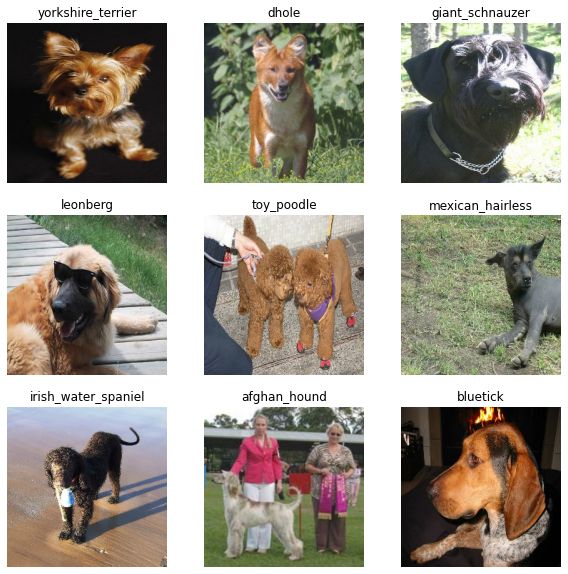

In [15]:
import matplotlib.pyplot as plt


def format_label(label):
    # this is a method on tfds.features.ClassLabel https://www.tensorflow.org/datasets/api_docs/python/tfds/features/ClassLabel#int2str
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

In [16]:
# data augmentation step
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

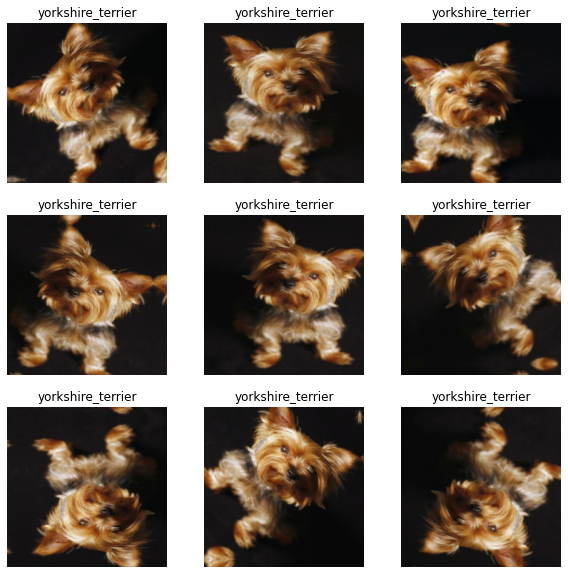

In [17]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # I thnk this is done to add an outer batch dimension.
        # Sometimes tf.nn.conv2d (or the tf network being used requires certain dimensionality)
        aug_img = img_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")

In [18]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

In [19]:
from tensorflow.keras.applications import EfficientNetB0

with strategy.scope():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

model.summary()

epochs = 40  # @param {type: "slider", min:10, max:100}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)

ValueError: Exception encountered when calling layer "normalization_4" (type Normalization).

Dimensions must be equal, but are 224 and 3 for '{{node efficientnetb0/normalization_4/sub}} = Sub[T=DT_FLOAT](efficientnetb0/rescaling_4/add, efficientnetb0/normalization_4/sub/y)' with input shapes: [?,224,224,3], [1,3,1,1].

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)